### Step 1: Introduction

- Problem statement: Detect fraudulent transactions.

- Dataset description: Fields like type, amount, oldbalanceOrg, isFraud.

- Goals: EDA, preprocessing, modeling, evaluation, model deployment.

In [1]:
# !pip install imblearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
# from imblearn.over_sampling import SMOTE
import joblib


**1-1** Loading dataset and exploring it

In [2]:
data = pd.read_csv("C:/Users/niloa/Desktop/MyFiles/FraudDetection/data/raw/fraud.csv")

data.info()
data.describe()
counts = data['isFraud'].value_counts()
print("Class Distribution:\n", counts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Class Distribution:
 0    6354407
1       8213
Name: isFraud, dtype: int64


In [3]:
types= data["type"].unique()
print("Unique Transaction Types:\n", types)
typecount = data["type"].value_counts()
print("Transaction Types:\n", typecount)

Unique Transaction Types:
 ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
Transaction Types:
 CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


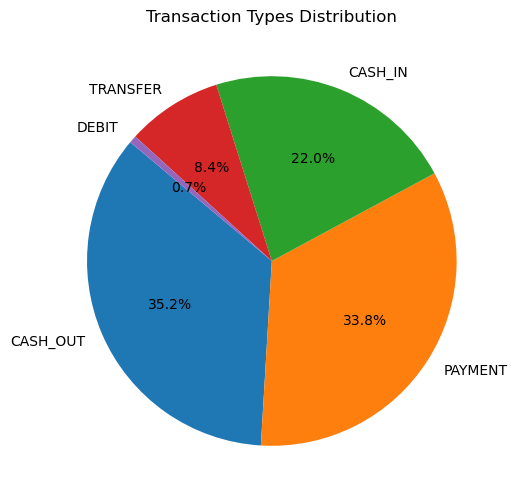

In [4]:
plt.figure(figsize=(6,6))
plt.pie(typecount, labels=typecount.index, autopct='%1.1f%%', startangle=140)
plt.title('Transaction Types Distribution')
plt.show()

**1-2** Exploring Data Analysis(EDA)

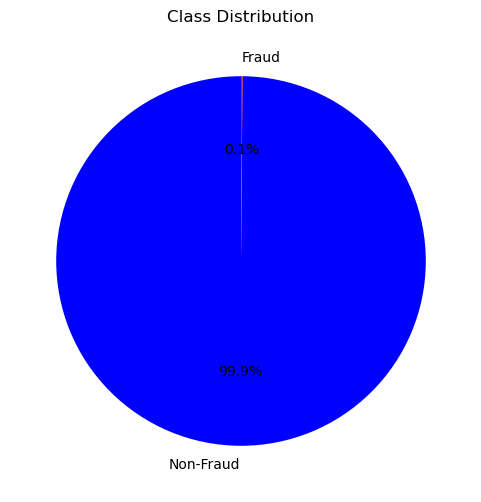

In [5]:
#General Distribution
plt.figure(figsize=(6,6))
plt.pie(counts.values, labels=['Non-Fraud', 'Fraud'], 
        autopct='%1.1f%%', colors=['blue','red'], startangle=90)
plt.title("Class Distribution")
plt.show()

In [6]:
fraudtypes = data[data["isFraud"] ==1]["type"].value_counts()
print("frad transaction types:\n", fraudtypes)

                  

frad transaction types:
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


**Fraud vs Non-Fraud Transaction Distribution**

The charts below provide a detailed look at transaction patterns:

- **Fraudulent Transactions (Top Left)**  
  - Almost all fraud occurs in **TRANSFER** and **CASH_OUT** transaction types.  
  - Other transaction types such as **PAYMENT**, **DEBIT**, and **CASH_IN** show **no fraud cases** in the dataset.  

- **Non-Fraudulent Transactions (Top Right)**  
  - Non-fraud cases are present across all transaction types.  
  - The majority of legitimate transactions are **CASH_OUT**, followed by **PAYMENT** and **CASH_IN**.  

- **Fraud Rate (Bottom)**  
  - The fraud rate (fraudulent / total transactions) is significantly higher in **TRANSFER** and **CASH_OUT**, confirming they are the most **risky transaction types**.  
  - Other transaction types have a fraud rate of **0%**.  

📊 **Key Takeaway**:  
Fraud detection models should pay special attention to **TRANSFER** and **CASH_OUT transactions**, as they account for nearly all fraudulent activity in the dataset.


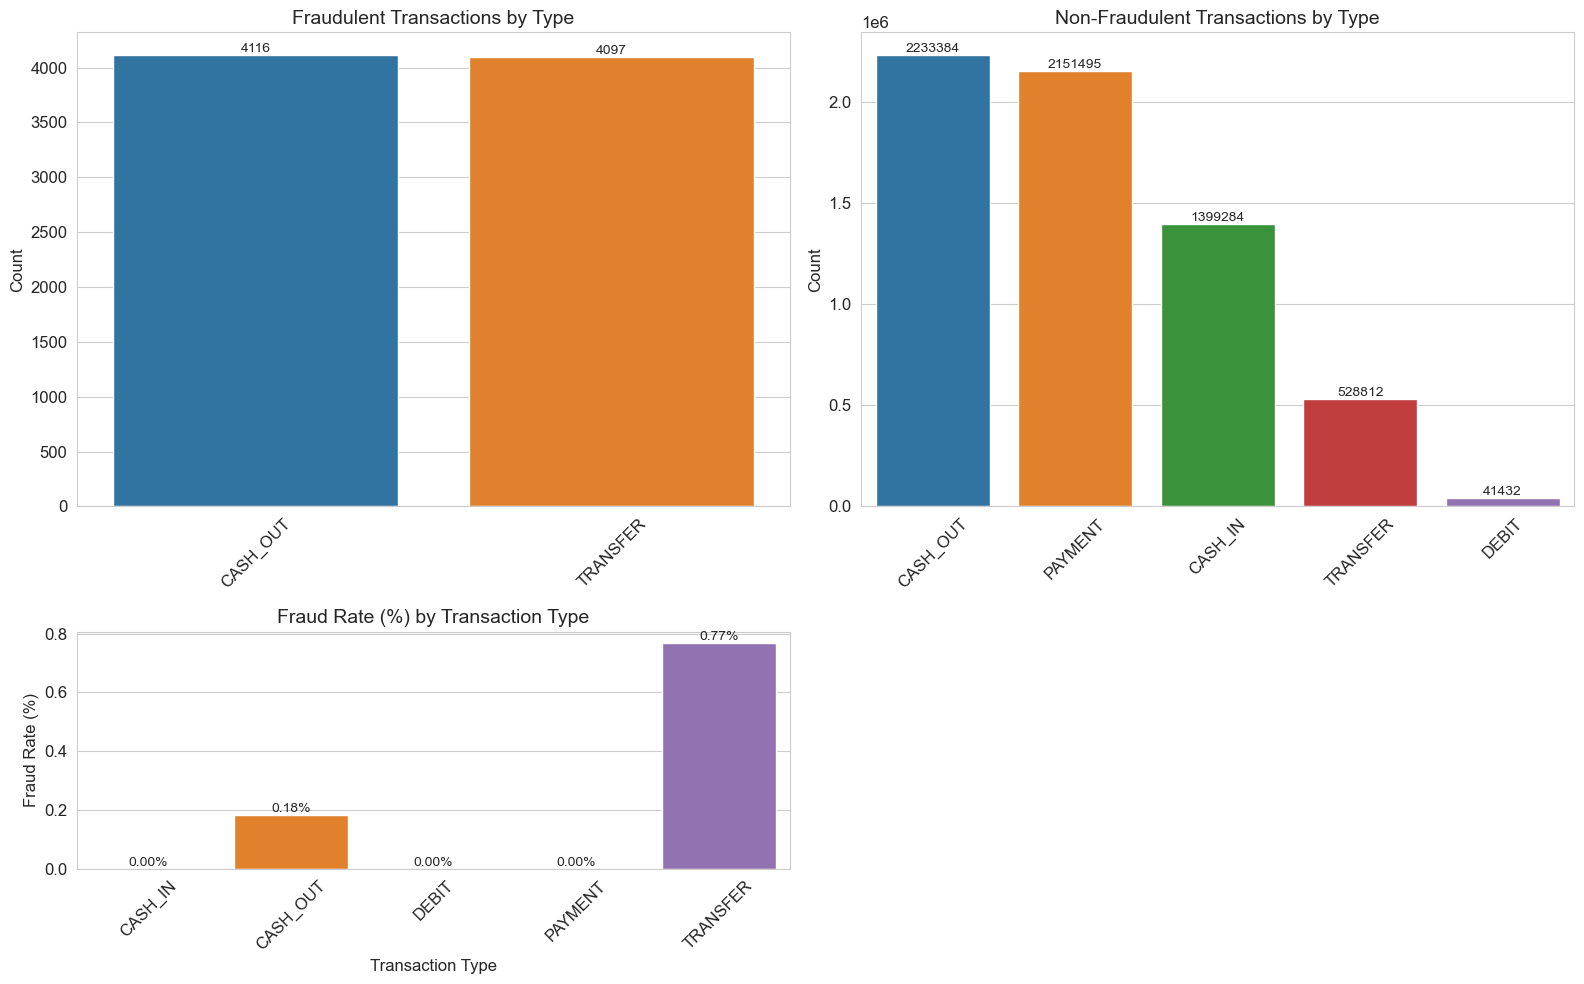

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fraud_only = data[data["isFraud"] == 1]
nonfraud_only = data[data["isFraud"] == 0]

# Fraud rate per type
fraud_rate = (
    data.groupby("type")["isFraud"]
    .mean() * 100
).reset_index()

# Style settings
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(2, 2, figsize=(16,10), gridspec_kw={'height_ratios':[2,1]})

### Fraud count plot
sns.countplot(
    x="type", data=fraud_only, 
    order=fraud_only["type"].value_counts().index,
    
    ax=axes[0,0]
)
axes[0,0].set_title("Fraudulent Transactions by Type", fontsize=14)
axes[0,0].set_xlabel("")
axes[0,0].set_ylabel("Count")
axes[0,0].tick_params(axis='x', rotation=45)

# Add counts on bars
for p in axes[0,0].patches:
    axes[0,0].annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=10)

### Non-Fraud count plot
sns.countplot(
    x="type", data=nonfraud_only, 
    order=nonfraud_only["type"].value_counts().index,
    
    ax=axes[0,1]
)
axes[0,1].set_title("Non-Fraudulent Transactions by Type", fontsize=14)
axes[0,1].set_xlabel("")
axes[0,1].set_ylabel("Count")
axes[0,1].tick_params(axis='x', rotation=45)

# Add counts on bars
for p in axes[0,1].patches:
    axes[0,1].annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=10)

### Fraud rate plot
sns.barplot(
    x="type", y="isFraud", data=fraud_rate,
    
    ax=axes[1,0]
)
axes[1,0].set_title("Fraud Rate (%) by Transaction Type", fontsize=14)
axes[1,0].set_ylabel("Fraud Rate (%)")
axes[1,0].set_xlabel("Transaction Type")
axes[1,0].tick_params(axis='x', rotation=45)

# Add percentages on bars
for p in axes[1,0].patches:
    axes[1,0].annotate(f'{p.get_height():.2f}%', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=10)

# Remove the unused subplot
fig.delaxes(axes[1,1])

plt.tight_layout()
plt.show()


Exploring the "Amount" distribution of the transactions is also important beacause fraudsters often behave differently in terms of amounts. 

- **Overall distribution**  
  - Fraudulent transactions are more frequent at **higher amounts**, visible when using a log scale.  
  - Non-fraud transactions are spread across all ranges but dominate smaller amounts.

- **TRANSFER vs CASH_OUT**  
  - Fraudulent **TRANSFER** transactions tend to occur at relatively **high amounts** compared to non-fraud transfers.  
  - In **CASH_OUT**, fraudulent amounts are also higher on average, but there is more overlap with legitimate ones.  

- **Boxplot insight**  
  - Fraudulent transactions show a **higher median amount** than non-fraudulent ones in both TRANSFER and CASH_OUT.  
  - Outliers are more extreme in fraud cases, confirming that fraudsters often attempt larger transactions.  

📊 **Key Takeaway**:  
Amount is an important predictor of fraud, especially in **TRANSFER** and **CASH_OUT**, where higher values are strongly associated with fraudulent activity.

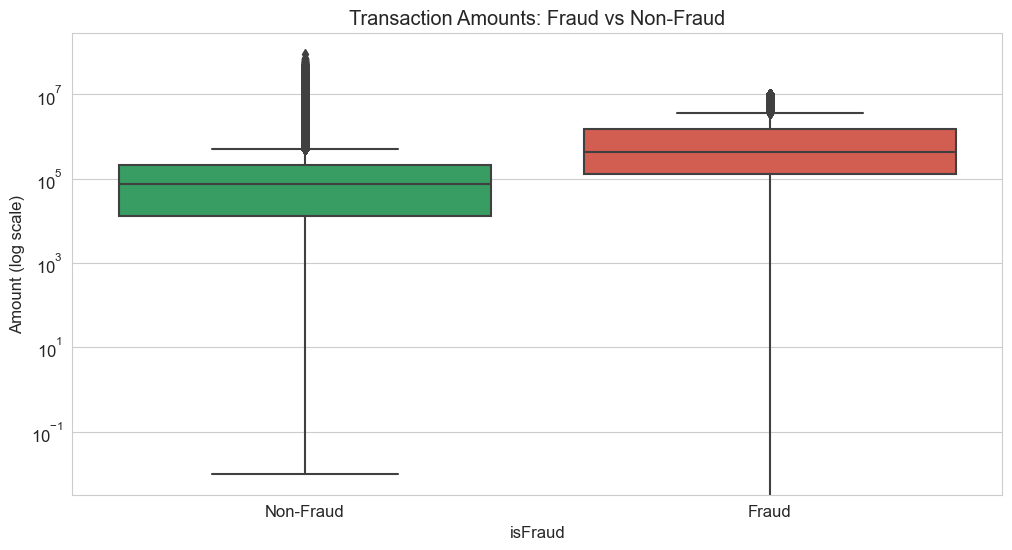

In [10]:
plt.figure(figsize=(12,6))
sns.boxplot(x="isFraud", y="amount", data=data, palette=["#27AE60", "#E74C3C"])
plt.yscale("log")  # log scale for better visualization
plt.xticks([0,1], ["Non-Fraud", "Fraud"])
plt.title("Transaction Amounts: Fraud vs Non-Fraud")
plt.ylabel("Amount (log scale)")
plt.show()


"Most non-fraud transactions occur at lower amounts, whereas fraud transactions, though rare, often involve higher amounts, as shown by the boxplot.”

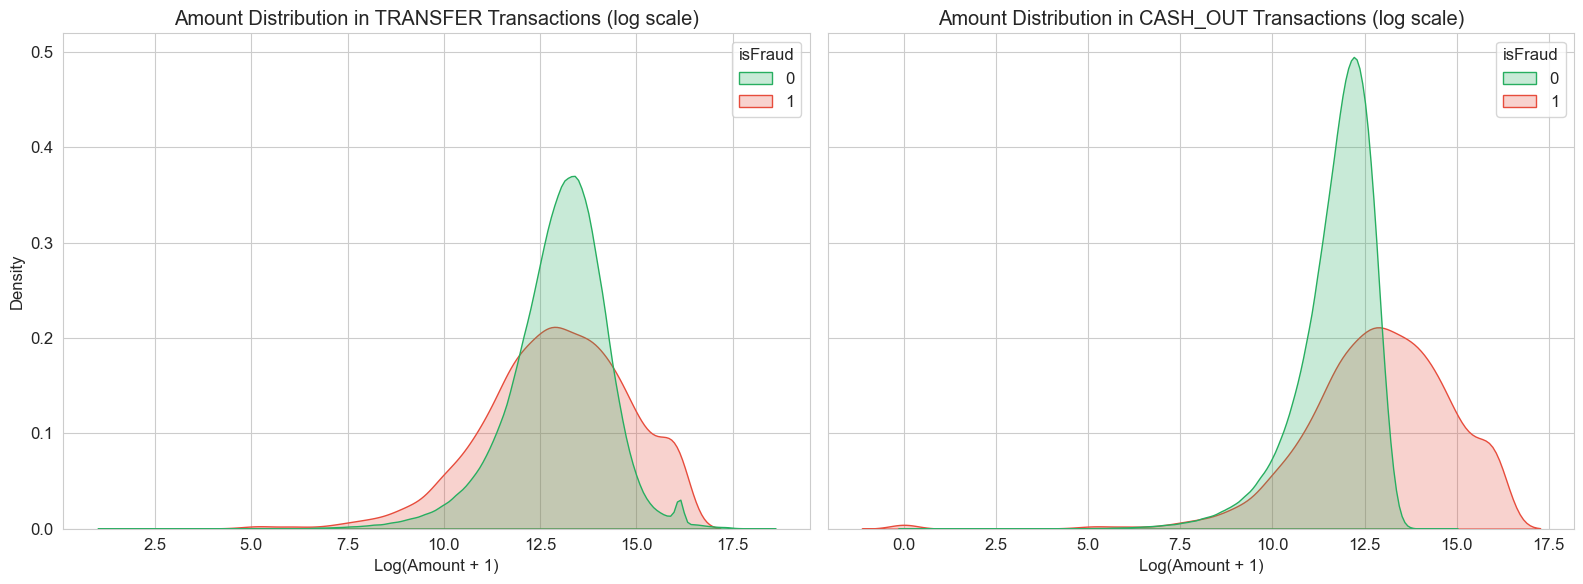

In [11]:
# Log-transform the amount to handle large range
data['log_amount'] = np.log1p(data['amount'])

fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# TRANSFER
sns.kdeplot(
    data=data[data["type"]=="TRANSFER"], 
    x="log_amount", 
    hue="isFraud", 
    fill=True, 
    palette=["#27AE60", "#E74C3C"], 
    ax=axes[0],
    common_norm=False  # scales each class separately
)

axes[0].set_title("Amount Distribution in TRANSFER Transactions (log scale)")
axes[0].set_xlabel("Log(Amount + 1)")
axes[0].set_ylabel("Density")

# CASH_OUT
sns.kdeplot(
    data=data[data["type"]=="CASH_OUT"], 
    x="log_amount", 
    hue="isFraud", 
    fill=True, 
    palette=["#27AE60", "#E74C3C"], 
    ax=axes[1],
    common_norm=False
)

axes[1].set_title("Amount Distribution in CASH_OUT Transactions (log scale)")
axes[1].set_xlabel("Log(Amount + 1)")

plt.tight_layout()
plt.show()


Observation: The KDE plots show that fraud transactions (red) have very similar amount distributions in both TRANSFER and CASH_OUT types.

Interpretation: Fraudsters tend to operate within similar amount ranges regardless of transaction type, suggesting that type alone may not strongly separate fraud from non-fraud.

**Balance Changes:**
Shows how the sender’s and receiver’s balances change. Fraud often drains the sender completely or creates unusual patterns in receiver balances.

C:\Users\niloa\AppData\Local\Temp\ipykernel_9448\2260294478.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=data, x='isFraud', y='diffOrig', jitter=True, palette=["#27AE60", "#E74C3C"])


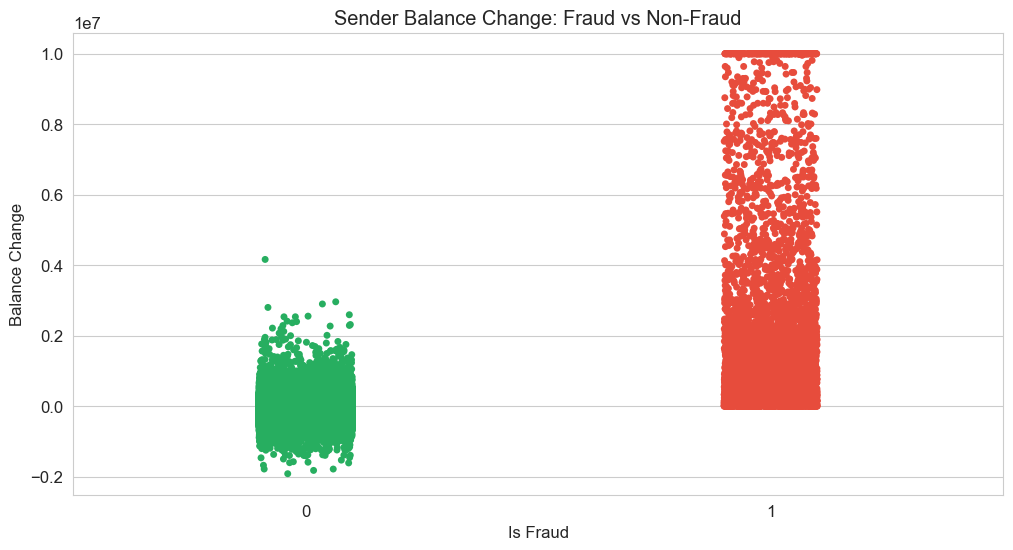

In [12]:
# Create new features: balance differences
data['diffOrig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['diffDest'] = data['newbalanceDest'] - data['oldbalanceDest']

plt.figure(figsize=(12,6))
sns.stripplot(data=data, x='isFraud', y='diffOrig', jitter=True, palette=["#27AE60", "#E74C3C"])
plt.title("Sender Balance Change: Fraud vs Non-Fraud")
plt.xlabel("Is Fraud")
plt.ylabel("Balance Change")
plt.show()


**Non-fraud (0):** points mostly between -0.2 and 0.2

✅ Meaning: for normal transactions, the sender’s balance barely changes after the transaction. This makes sense for payments and transfers where the money leaves the account in a predictable way.

**Fraud (1):** points spread between 0 and 1

⚠️ Meaning: fraudulent transactions often have larger or unusual changes in sender balances. This could happen if money is moved in unusual ways or the transaction is only partially recorded on the sender’s side.

**How did Fraud Transactions change the origin and destination accounts?**

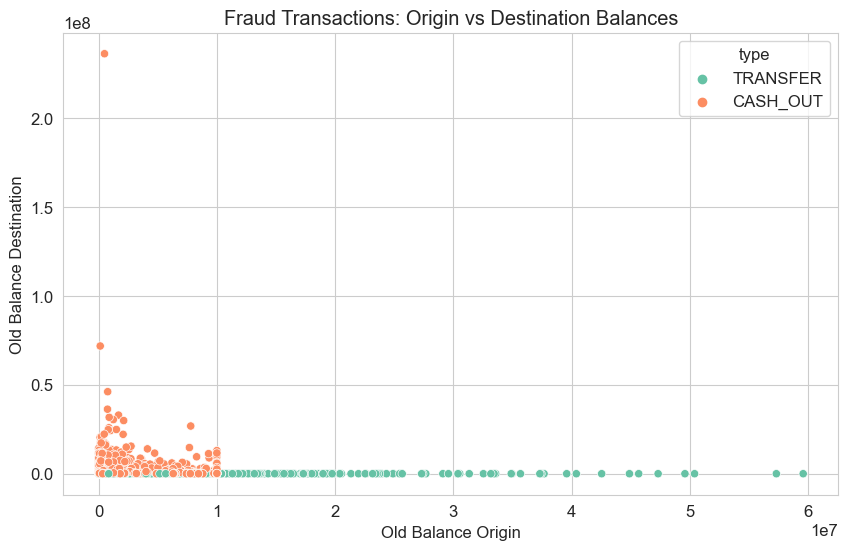

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data[data['isFraud']==1], x='oldbalanceOrg', y='oldbalanceDest', hue='type', palette='Set2')
plt.title("Fraud Transactions: Origin vs Destination Balances")
plt.xlabel("Old Balance Origin")
plt.ylabel("Old Balance Destination")
plt.show()

This plot is only for fraud transactions in two categories: "TRANSFER" and "CASH_OUT". 

- x-axis (oldbalanceOrg): sender’s balance before the transaction

- y-axis (oldbalanceDest): receiver’s balance before the transaction

- hue (type): shows different types of fraudulent transactions with colors

We can see that most fraudulent transactions often involve empty or very low-balance accounts, which is common in money laundering or stolen accounts. Specifically, CASH_OUT transaction are highly clustered near the axes, whereas TRANSFER fraud could occur across a wider range of balances.
And with the "TRANSFER" type of transaction one can easily notice that the origin account has some balance (x-axis), but the destination account is always showing 0.
This likely means the fraudsters transfer money to accounts that start with zero balance, or the destination balance wasn’t recorded/updated.

## 🔧 Feature Engineering

To improve fraud detection performance, we derived several engineered features:

1. **Balance change features**
   - `delta_orig`: actual money leaving origin account  
   - `delta_dest`: actual money arriving at destination account  
   - `error_orig` / `error_dest`: difference between expected and actual balance updates  

2. **Amount transformation**
   - `log_amount`: log-transformed transaction amount to reduce skewness  

3. **Relative ratios**
   - `balance_ratio_org`: transaction size relative to sender’s old balance  
   - `balance_ratio_dest`: transaction size relative to receiver’s old balance  

4. **Transaction type encoding**
   - One-hot encoding of transaction type  
   - Flag for risky types (`TRANSFER`, `CASH_OUT`)  

5. **Account consistency**
   - `is_same_name`: flag when origin and destination names are identical  

These features aim to highlight suspicious behaviors such as:
- Inconsistencies between transaction amount and balance updates  
- Full-balance transfers or transactions into empty accounts  
- High-risk transaction types that dominate fraud patterns  



In [14]:
#Prepare the dataset for futher analysis and extract useful features for modeling
df = data.copy()

# 1. Balance changes
# How much actually left origin / arrived at destination
df['delta_orig'] = df['oldbalanceOrg']   - df['newbalanceOrig']  
df['delta_dest'] = df['newbalanceDest']  - df['oldbalanceDest'] 
# 0 means balances are consistent with the transfer amount
df['error_orig'] = df['amount'] - df['delta_orig']
df['error_dest'] = df['amount'] - df['delta_dest']



# 2. Log-transform amount
df["log_amount"] = np.log1p(data["amount"])

# 3. Ratios
df["balance_ratio_org"] = df["amount"] / (df["oldbalanceOrg"] + 1)
df["balance_ratio_dest"] = df["amount"] / (df["oldbalanceDest"] + 1)

# 4. Encode transaction type
df = pd.get_dummies(df, columns=["type"], drop_first=True)
#A flag for risky types
df['is_transfer_or_cashout'] = (
    (df.get('type_TRANSFER', 0) == 1) | (df.get('type_CASH_OUT', 0) == 1)
).astype(int)

# 5. Name consistency
df['is_same_name']       = (df['nameOrig'] == df['nameDest']).astype(int) 

df.head()


,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,...,error_orig,error_dest,balance_ratio_org,balance_ratio_dest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,is_transfer_or_cashout,is_same_name
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,...,-1.455192e-11,9839.64,0.057834,9839.640000,0,0,1,0,0,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,...,1.136868e-12,1864.28,0.087731,1864.280000,0,0,1,0,0,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,...,0.000000e+00,181.00,0.994505,181.000000,0,0,0,1,1,0
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,...,0.000000e+00,21363.00,0.994505,0.008545,1,0,0,0,1,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,...,0.000000e+00,11668.14,0.280788,11668.140000,0,0,1,0,0,0


In [15]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop(columns=["isFraud", "nameOrig", "nameDest"])  
y = df["isFraud"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.91      0.95   1906322
           1       0.01      0.90      0.03      2464

    accuracy                           0.91   1908786
   macro avg       0.51      0.90      0.49   1908786
weighted avg       1.00      0.91      0.95   1908786

ROC-AUC: 0.9629269539184498


In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200, max_depth=10, random_state=42, class_weight="balanced"
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      1.00      1.00      2464

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC: 0.9998397272586046


In [18]:
import pandas as pd

feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).head(10)


balance_ratio_org         0.182651
error_orig                0.170020
diffOrig                  0.152254
delta_orig                0.144489
is_transfer_or_cashout    0.085520
newbalanceOrig            0.072413
oldbalanceOrg             0.041179
balance_ratio_dest        0.039009
log_amount                0.019733
type_PAYMENT              0.018628
dtype: float64

In [19]:
leakage_features = ["error_orig", "error_dest", "delta_orig", "diffOrig"]
X1 = df.drop(columns=["isFraud"] + leakage_features)
y1 = df["isFraud"]
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1, y1, test_size=0.3, random_state=42, stratify=y
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200, max_depth=10, random_state=42, class_weight="balanced"
)
rf.fit(X_train1, y_train1)

y_pred = rf.predict(X_test1)
y_prob = rf.predict_proba(X_test1)[:, 1]

print("Random Forest")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      1.00      1.00      2464

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC: 0.9998397272586046
